<a href="https://colab.research.google.com/github/Hrithik2212/CNN-Cat-And-Dog-Classification-with-PyTorch-/blob/main/01_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Dogs and Cats with VGG Models 

In [13]:
# imports
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from PIL import Image
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv 
from glob import glob
import torchsummary
import numpy as np, pandas as pd , matplotlib.pyplot as plt
import seaborn as sns 
from torch.utils.data import Dataset , DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.modules.pooling import MaxPool2d
from pathlib import Path
import random
from PIL import Image

In [14]:
# device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
!nvidia-smi

Sun Aug 28 05:32:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Wrangling

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

## Data Preparation 

In [17]:
train_dir = 'training_set/training_set'
test_dir = 'test_set/test_set'
class cat_dogs_ds(Dataset):
    def __init__(self,folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats + dogs 
        from random import shuffle, seed; seed(10);
        shuffle(self.fpaths)
        self.target = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog = 1 , cat = 0 
    
    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self , ix ):
        fp = self.fpaths[ix]
        target = self.target[ix]
        im = cv.imread(fp)[:,:,::-1]
        im = cv.resize(im , (224,224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(),torch.tensor([target]).float().to(device)

 0 : Cat
 1 : Dog
tensor([0.], device='cuda:0')


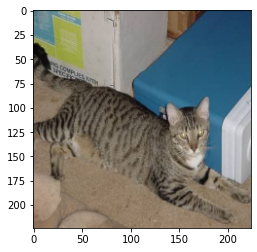

In [18]:
data = cat_dogs_ds(train_dir)
im , label = data[102]
plt.imshow(im.permute(1,2,0).cpu())
print (f' 0 : Cat\n 1 : Dog')
print(label)

In [19]:
test_data = cat_dogs_ds(test_dir)

## Model Building 

In [21]:
Model_0_VGG16 =  models.vgg16(pretrained=True).to(device)
for param in Model_0_VGG16.parameters():
 param.requires_grad = False
Model_0_VGG16.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)).to(device)
Model_0_VGG16.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(512, 128),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(128, 1),
                                        nn.Sigmoid()).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(Model_0_VGG16.parameters(),lr= 1e-3)
torchsummary.summary(Model_0_VGG16, (3,224,224));

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [22]:
def get_data():
    train = cat_dogs_ds(train_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = cat_dogs_ds(test_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

train_dl , val_dl = get_data()
# Train Function 

def train_batch(x,y,model,opt,loss_fn):
    model.train()
    y_preds = model(x)
    batch_loss = loss_fn(y_preds , y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# Accuracy function 
@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()  

## Model Training

In [23]:
EPOCHS= 10
train_losses , train_accuricies = [] , []
val_losses , val_accuracies = [] , []
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}')
    train_epoch_losses , train_epoch_accuracies = [] , []
    val_epoch_accuracies = [] 
    for ix , batch in enumerate(iter(train_dl)):
        x  ,y = batch
        batch_loss = train_batch(x,y,Model_0_VGG16,optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.mean(train_epoch_losses)

    for ix ,batch in enumerate(iter(train_dl)):
        x , y = batch
        is_correct = accuracy(x , y, Model_0_VGG16)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix , batch in enumerate(iter(val_dl)):
        x , y = batch 
        val_is_crt = accuracy(x,y,Model_0_VGG16)
        val_epoch_accuracies.extend(val_is_crt)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(f'Train Loss {train_epoch_loss:.4f} | Train Accuracy {train_epoch_accuracy:.2f} | Val Accuracy {val_epoch_accuracy:.2f}')
    print(f'Done============================================================')
    train_losses.append(train_epoch_loss)
    train_accuricies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

EPOCH 1
Train Loss 0.1372 | Train Accuracy 0.97 | Val Accuracy 0.97
Done============================================================
EPOCH 2
Train Loss 0.0799 | Train Accuracy 0.97 | Val Accuracy 0.97
Done============================================================
EPOCH 3
Train Loss 0.0698 | Train Accuracy 0.98 | Val Accuracy 0.97
Done============================================================
EPOCH 4
Train Loss 0.0644 | Train Accuracy 0.98 | Val Accuracy 0.97
Done============================================================
EPOCH 5
Train Loss 0.0604 | Train Accuracy 0.98 | Val Accuracy 0.97
Done============================================================
EPOCH 6
Train Loss 0.0533 | Train Accuracy 0.98 | Val Accuracy 0.97
Done============================================================
EPOCH 7
Train Loss 0.0517 | Train Accuracy 0.98 | Val Accuracy 0.97
Done============================================================
EPOCH 8
Train Loss 0.0452 | Train Accuracy 0.99 | Val Accuracy 0.97
D